<a href="https://colab.research.google.com/github/jugernaut/Prometeo/blob/desarrollo/02_AlgebraLineal/06_Normas/07_NormasInducidasAplicaciones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Normas Inducidas Aplicación
### Proyecto PAPIME PE101019
- Autor: Miguel Angel Pérez León
- Rev: mar oct  1 17:08:27 CDT 2020

## Introducción

Las redes neuronales y el aprendizaje de máquina es de las areas de las ciencias que han tenido más desarrollo en las últimas epocas.

Y una de las areas en las que mayor aplicación han tenido estas disciplinas es en la **clasificicación automatizada**.

Supongamos que nos interesa clasificar colores y dado que los colores se pueden ver como vectores con 3 componentes entonces podemos establecer distancias entre estos vectores para determinar que tan "similares" o "distintos" son unos de otros.

A partir de este concepto de "distancia" (norma en un espacio vectorial) podemos comenzar a clasificar cualquier cosa que pueda ser caracterizada por un vector.

TensorFlow is already loaded. Please restart the runtime to change versions.
Instructions for updating:
Use `tf.global_variables_initializer` instead.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


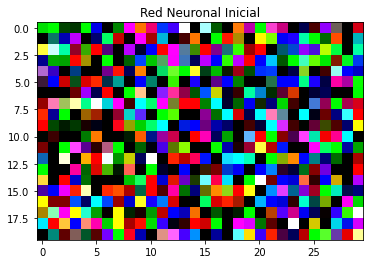

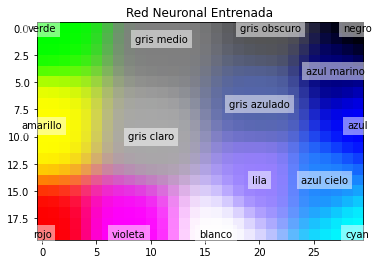

(14, 26)


In [3]:
##!pip install tensorflow==1.1
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
%tensorflow_version 1.x
 
class SOM(object):
    """
    Clase que representa una red neuronal tipo SOM.
    """
 
    #To check if the SOM has been trained
    _trained = False
 
    def __init__(self, m, n, dim, n_iterations=100, alpha=None, sigma=None):
        """
        Constructor que toma como parametros los valores descritos en el
        algoritmo SOM. Genera un mapa de m renglones por n columnas y se entrenara
        con n_iterations
        """
 
        #Se inicializan variables que seran usadas a lo largo del coidgo
        self._m = m
        self._n = n
        if alpha is None:
            alpha = 0.3
        else:
            alpha = float(alpha)
        if sigma is None:
            sigma = max(m, n) / 2.0
        else:
            sigma = float(sigma)
        self._n_iterations = abs(int(n_iterations))
 
        '''SE NECESITA UNA GRAFICA (PLANO), hay una grafica
        por default pero la guardamos en _graph'''
        self._graph = tf.Graph()
 
        '''SE CREAN LOS ELEMENTOS NECESARIOS EN LA GRAFICA'''
        with self._graph.as_default():
            '''SE CREAN TODAS LAS NEURONAS CON tf.Variable, son m*n
            neuronas con dim pesos, que seran comparados con los pesos
            de la entrada y la que tenga la menor distancia sera la
            neurona ganadora. Antes de iniciar el entrenamiento, hay
            hay que inicializar TODAS las variables'''
            
            '''Lista de pesos de los vectores de la red neuronal'''
            self._weightage_vects = tf.Variable(tf.random_normal(
                [m*n, dim]))
 
            '''Lista de 600 entradas, y cada entrada representa una
            coordenada en la cual se encuentra cada neurona'''
            self._location_vects = tf.constant(np.array(
                list(self._neuron_locations(m, n))))
 
            '''self._vect_input es un placeholder de tamano dim, ya que
            es el objeto que sera alimentado con el vector de entrada y
            a su vez este sera comparado con los pesos de cada neurona.
            Esto es asi por el framework que da tensorflow'''
            self._vect_input = tf.placeholder("float", [dim])
            
            '''Lo mismo sucede con esta variable, la diferencia es que en
            este punto aun no se sabe cuantas iteraciones (epocas) seran
            necesarias, asi que se deja en cero.'''
            self._iter_input = tf.placeholder("float")
 
            '''Devuelve el indice con el menor valor, es decir la neurona mas cercana.'''
            bmu_index = tf.argmin(tf.sqrt(tf.reduce_sum(
                tf.pow(tf.subtract(self._weightage_vects, tf.stack(
                    [self._vect_input for i in range(m*n)])), 2), 1)),
                                  0)
 
            '''Variable que guarda el indice y un espacio para el sus
            coordenada'''
            slice_input = tf.pad(tf.reshape(bmu_index, [1]),
                                 np.array([[0, 1]]))
            bmu_loc = tf.reshape(tf.slice(self._location_vects, slice_input,
                                          tf.constant(np.array([1, 2]))),
                                 [2])
 
            '''Valores necesario para actualizar los pesos de las neuronas
            de acuerdo a la iteracion (epoca)'''
            learning_rate_op = tf.subtract(1.0, tf.div(self._iter_input,
                                                  self._n_iterations))
            _alpha_op = tf.multiply(alpha, learning_rate_op)
            _sigma_op = tf.multiply(sigma, learning_rate_op)
 
            '''Calcula las distancias al cuadrado por cada neurona con respecto
            a la neurona GANADORA (BMU). De tal manera que estos valores
            puedan ser empleados para actualizar los pesos de los vecinos'''
            bmu_distance_squares = tf.reduce_sum(tf.pow(tf.subtract(
                self._location_vects, tf.stack(
                    [bmu_loc for i in range(m*n)])), 2), 1)
            neighbourhood_func = tf.exp(tf.negative(tf.div(tf.cast(
                bmu_distance_squares, "float32"), tf.pow(_sigma_op, 2))))
            learning_rate_op = tf.multiply(_alpha_op, neighbourhood_func)
 
            '''Tasa de aprendizaje para actualizar los pesos de las neuronas'''
            learning_rate_multiplier = tf.stack([tf.tile(tf.slice(
                learning_rate_op, np.array([i]), np.array([1])), [dim])
                                               for i in range(m*n)])
            weightage_delta = tf.multiply(
                learning_rate_multiplier,
                tf.subtract(tf.stack([self._vect_input for i in range(m*n)]),
                       self._weightage_vects)) 
            
            '''Actualiza todos los pesos de las neuronas de acuerdo a los
            parametros calculados previamente'''                                        
            new_weightages_op = tf.add(self._weightage_vects,
                                       weightage_delta)
            
            '''Se guarda la ultima operacion realizada en la SOM, ya que
            esta operacion sera la que se ejecute y a su vez ejecuta todas
            las operaciones previar al llamar a sess.run()'''
            self._training_op = tf.assign(self._weightage_vects,
                                          new_weightages_op)                                       
 
            '''En tensorflow todo debe ocurrir dentro de una sesion, es por
            este motivo que se guarda la sesion'''
            self._sess = tf.Session()
 
            '''Forma en la tensorflow inicializa sus variables antes de ser
            utilizadas'''
            init_op = tf.initialize_all_variables()
            self._sess.run(init_op)
            
            '''centroid_grid es un mapa de bits en el cual se guardan los
            valores de las neuronas. Es de tamano m, por que para cada renglon
            se tienen n neuronas y sus respectivos valores. '''
            centroid_grid = [[] for i in range(self._m)]
            self._weightages = list(self._sess.run(self._weightage_vects))
            self._locations = list(self._sess.run(self._location_vects))
    
            '''Con este for, se accede a cada neurona por posicion y se guarda
            en centroid_grid sus pesos. El resultado es un mapa de bits que puede
            ser facilmente graficado por matplotlib. Es el mapa incial (SIN ENTRENAR)'''
            for i, loc in enumerate(self._locations):
                centroid_grid[loc[0]].append(self._weightages[i])
            self._mapa_inicial = centroid_grid
 
    def _neuron_locations(self, m, n):
        '''Yield regresa un generador flojo, y hasta que es necesario
        se evalua. Esto se hace para que no haya informacion no necesaria
        en memoria. En el constructor el resultado de esta funcion se
        mete en una lista para que sea accesible de inmediato'''
        for i in range(m):
            for j in range(n):
                yield np.array([i, j])
 
    def train(self, input_vects):
        '''Para cada iteracion (epoca) se realiza el entrenamiento'''
        for iter_no in range(self._n_iterations):
            #Train with each vector one by one
            for input_vect in input_vects:
                self._sess.run(self._training_op,
                               feed_dict={self._vect_input: input_vect,
                                          self._iter_input: iter_no})
 
        '''centroid_grid es un mapa de bits en el cual se guardan los
            valores de las neuronas. Es de tamano m, por que para cada renglon
            se tienen n neuronas y sus respectivos valores. '''
        centroid_grid = [[] for i in range(self._m)]
        self._weightages = list(self._sess.run(self._weightage_vects))
        self._locations = list(self._sess.run(self._location_vects))
        
        '''Con este for, se accede a cada neurona por posicion y se guarda
            en centroid_grid sus pesos. El resultado es un mapa de bits que puede
            ser facilmente graficado por matplotlib. En este punto la red ya esta entrenada.'''
        for i, loc in enumerate(self._locations):
            centroid_grid[loc[0]].append(self._weightages[i])
        self._centroid_grid = centroid_grid
 
        '''En este punto la red ya esta entrenada.'''
        self._trained = True
 
    def get_centroids(self):
        # Solo devuelve los centroides para que puendan ser graficados
        if not self._trained:
            raise ValueError("La red aun no ha sido entrenada")
        return self._centroid_grid
 
    def map_vects(self, input_vects):
        '''to_return es la lista que contiene las coordenadas (x,y) de la
        neurona que mas se parece a cada una de las entradas de input_vects
        en el mismo orden'''
 
        if not self._trained:
            raise ValueError("SOM not trained yet")
 
        to_return = []
        for vect in input_vects:
            min_index = min([i for i in range(len(self._weightages))],
                            key=lambda x: np.linalg.norm(vect-
                                                         self._weightages[x]))
            to_return.append(self._locations[min_index])
 
        return to_return
    
    def map_vect(self, vect):
        '''
        Mapea un solo vector y devuelve la clasificacion vista como
        un indice relacionado a la coordenada (x,y) de la neurona
        '''

        min_index = min([i for i in range(len(self._weightages))],
                        key=lambda x: np.linalg.norm(
                            vect - self._weightages[x]))
        pos2D = self._locations[min_index]
        # polinomio de direccionamiento de la neurona
        #return pos2D[0]*self._m + pos2D[1], pos2D
        return (pos2D[0], pos2D[1])
 
# Vectores de entrenamiento RGBcolors
colors = np.array(
     [[0., 0., 0.],
      [0., 0., 1.],
      [0., 0., 0.5],
      [0.125, 0.529, 1.0],
      [0.33, 0.4, 0.67],
      [0.6, 0.5, 1.0],
      [0., 1., 0.],
      [1., 0., 0.],
      [0., 1., 1.],
      [1., 0., 1.],
      [1., 1., 0.],
      [1., 1., 1.],
      [.33, .33, .33],
      [.5, .5, .5],
      [.66, .66, .66]])
color_names = \
    ['negro', 'azul', 'azul marino', 'azul cielo',
     'gris azulado', 'lila', 'verde', 'rojo',
     'cyan', 'violeta', 'amarillo', 'blanco',
     'gris obscuro', 'gris medio', 'gris claro']
 
# Creamos un SOM de 20x30 y se entrena 00 veces
som = SOM(20, 30, 3, 400)

# Se muestra el mapa inicial
mapa_inicial = som._mapa_inicial
plt.imshow(mapa_inicial)
plt.title('Red Neuronal Inicial')
plt.show()

# Se entrena la red con un conjunto de colores
som.train(colors)
 
# Obtenemos el SOM ya entrenado
image_grid = som.get_centroids()
 
# Contiene la lista de coordenadas de los correspondientes colores
mapped = som.map_vects(colors)
 
# Grafica
plt.imshow(image_grid)
plt.title('Red Neuronal Entrenada')
for i, m in enumerate(mapped):
    plt.text(m[1], m[0], color_names[i], ha='center', va='center',
             bbox=dict(facecolor='white', alpha=0.5, lw=0))
plt.show()

# Se le muestra un color para que indique a que neurona se parece mas
print(som.map_vect([0.125, 0.529, 1.0]))




De igual manera como se definió la norma en el espacio de los vectores en $\mathbb{R}^{n}$, en esta sección se procede a definir la norma para el espacio de las matrices $A\in M_{n\times n}$ sobre $\mathbb{R}$.

**Una función** $\left\Vert \cdot\right\Vert$ de matrices, se denomina norma matricial si $\left\Vert \cdot\right\Vert$  si para cualesquiera matrices $A, B$ de $n\times n$ se satisfacen las siguientes propiedades.

1.- $\left\Vert A\right\Vert \geq0$.\
2.- $\left\Vert A\right\Vert =0\,\Longleftrightarrow A=0$.\
3.- $\left\Vert \alpha A\right\Vert =\left|\alpha\right|\left\Vert A\right\Vert$.\
4.- $\left\Vert A+B\right\Vert \leq\left\Vert A\right\Vert +\left\Vert B\right\Vert$. (desigualdad triangular)\
5.- $\left\Vert AB\right\Vert \leq\left\Vert A\right\Vert \left\Vert B\right\Vert$ (compatibilidad o consistencia).

¿Conoces alguna función $\left(\left\Vert \cdot\right\Vert \right)$ que cumpla con las propiedades anteriores para el espacio de las matrices de $n\times n$?. 

In [ ]:
from SOM import SOM
import numpy as np
from matplotlib import pyplot as plt
 
# Vectores de entrenamiento RGBcolors
colors = np.array(
     [[0., 0., 0.],
      [0., 0., 1.],
      [0., 0., 0.5],
      [0.125, 0.529, 1.0],
      [0.33, 0.4, 0.67],
      [0.6, 0.5, 1.0],
      [0., 1., 0.],
      [1., 0., 0.],
      [0., 1., 1.],
      [1., 0., 1.],
      [1., 1., 0.],
      [1., 1., 1.],
      [.33, .33, .33],
      [.5, .5, .5],
      [.66, .66, .66]])
color_names = \
    ['negro', 'azul', 'azul marino', 'azul cielo',
     'gris azulado', 'lila', 'verde', 'rojo',
     'cyan', 'violeta', 'amarillo', 'blanco',
     'gris obscuro', 'gris medio', 'gris claro']
 
# Creamos un SOM de 20x30 y se entrena 00 veces
som = SOM(20, 30, 3, 400)

# Se muestra el mapa inicial
mapa_inicial = som._mapa_inicial
plt.imshow(mapa_inicial)
plt.title('Red Neuronal Inicial')
plt.show()

# Se entrena la red con un conjunto de colores
som.train(colors)
 
# Obtenemos el SOM ya entrenado
image_grid = som.get_centroids()
 
# Contiene la lista de coordenadas de los correspondientes colores
mapped = som.map_vects(colors)
 
# Grafica
plt.imshow(image_grid)
plt.title('Red Neuronal Entrenada')
for i, m in enumerate(mapped):
    plt.text(m[1], m[0], color_names[i], ha='center', va='center',
             bbox=dict(facecolor='white', alpha=0.5, lw=0))
plt.show()

# Se le muestra un color para que indique a que neurona se parece mas
print som.map_vect([0.125, 0.529, 1.0])



SyntaxError: ignored

## Normas Matricial inducida (subordinada)

**Definición.** Sea $p\geq1,\:\vec{x}\in\mathbb{R}^{n}$, la p-norma de una matriz $A\in M_{n\times n}$ esta definida por.

$$\left\Vert A\right\Vert _{p}:=\underset{x\neq0}{sup}\frac{\left\Vert A\vec{x}\right\Vert _{p}}{\left\Vert \vec{x}\right\Vert _{p}}$$

Norma matricial inducida por la 1-norma vectorial. 

$$\left\Vert A\right\Vert _{1}\:=\underset{x\neq0}{sup}\frac{\left\Vert A\vec{x}\right\Vert _{1}}{\left\Vert \vec{x}\right\Vert _{1}}\overset{\underbrace{*Teo\,1.}}{=}\underset{1\leq j\leq n}{max}\sum_{i=1}^{n}\left|a_{ij}\right|=\underset{1\leq j\leq n}{max}\left\Vert \vec{a}_{j}\right\Vert _{1}\:(suma\,columnas)$$

Norma matricial inducida por la norma del supremo.

$$\left\Vert A\right\Vert _{\infty}:=\underset{x\neq0}{sup}\frac{\left\Vert A\vec{x}\right\Vert _{\infty}}{\left\Vert \vec{x}\right\Vert _{\infty}}\overset{\underbrace{*Teo\,2.}}{=}\underset{1\leq i\leq n}{max}\sum_{j=1}^{n}\left|a_{ij}\right|=\underset{1\leq i\leq n}{max}\left\Vert \vec{a}_{i}\right\Vert _{\infty}\:(suma\,renglones)$$



## 1-Norma Matricial

Hecho. Recordatorio de álgebra lineal

Hecho. Sea $A=\left(\begin{array}{cc}
a_{11} & a_{12}\\
a_{21} & a_{22}
\end{array}\right)$ y $\vec{x}=\left(\begin{array}{c}
x_{1}\\
x_{2}
\end{array}\right)$ la operación $A\vec{x}$ esta definida como$$A\vec{x}=\left(\begin{array}{c}
a_{11}x_{1}+a_{12}x_{2}\\
a_{21}x_{1}+a_{22}x_{2}
\end{array}\right)=\left(\begin{array}{c}
c_{1}\\
c_{2}
\end{array}\right)$$

De tal manera que cada entrada $c_{i}$ la podemos ver como una sumatoria, es decir

$$\begin{eqnarray*}
c_{1}=\sum_{i=1}^{n} a_{1j}x_{j}\\
c_{2}=\sum_{j=1}^{2} a_{2j}x_{j}\end{eqnarray*}\tag{1}$$






## 1-Norma Matricial

Para poder demostrar que la 1-norma matricial de $A\in M_{n\times n}$ es el máximo de las normas de los vectores columnas es decir, $$\left\Vert A\right\Vert _{1}=\underset{1\leq j\leq n}{max}\left\Vert \vec{a}_{j}\right\Vert _{1}\tag{2}$$

Se necesita considerar lo mostrado en la celda anterior y pensar en la matriz A como una lista de columnas.

Prueba de (2)

Sea $\vec{x}\in\mathbb{R}^{n}$ y $A\in M_{n\times n}$ con $A=\left[\vec{a}_{1}|\vec{a}_{2}\text{|}\cdots\text{|}\vec{a}_{n}\right]$, donde $\vec{a}_{j}$ es un vector columna en $\mathbb{R}^{n}$. Consideremos la bola unitaria en la 1-norma $:=\left\{ \vec{x}\in\mathbb{R}^{n}\mid\left\Vert \vec{x}\right\Vert _{1}=\sum_{j=1}^{n}\left|x_{j}\right|\leq1\right\}$ . Cualquier vector $A\vec{x}$ satisface:

$$\left\Vert A\vec{x}\right\Vert _{1}	\overset{\underbrace{(1)}}{=}	\left\Vert \sum_{j=1}^{n}\vec{a}_{j}x_{j}\right\Vert _{1}\overset{\underbrace{prop\,4\,nor}}{\leq}\sum_{j=1}^{n}\left\Vert \vec{a}_{j}x_{j}\right\Vert _{1}\overset{\underbrace{prop\,3\,nor.}}{=}\sum_{j=1}^{n}\left\Vert \vec{a}_{j}\right\Vert _{1}\left|x_{j}\right|
	\overset{\underbrace{def.max.}}{\leq}	\underset{1\leq j\leq n}{max}\left\Vert \vec{a}_{j}\right\Vert _{1}\sum_{j=1}^{n}\left|x_{j}\right|\overset{\underbrace{bola\,unit.}}{\leq}\underset{1\leq j\leq n}{max}\left\Vert \vec{a}_{j}\right\Vert _{1}
\Longrightarrow	\left\Vert A\vec{x}\right\Vert _{1}	\leq\underset{1\leq j\leq n}{max}\left\Vert \vec{a}_{j}\right\Vert _{1}$$

Prueba. Si elegimos $\vec{x}=\vec{e}_{j}$ (es decir el vector canónico, ademas $\left\Vert \vec{e}_{j}\right\Vert _{1}=1)$ con un 1 en la entrada j. Donde j maximiza, $\left\Vert \vec{a}_{j}\right\Vert _{1}$, obtenemos la cota máxima.$$\therefore\left\Vert A\right\Vert _{1}=\underset{x\neq0}{sup}\frac{\left\Vert A\vec{x}\right\Vert _{1}}{\left\Vert \vec{x}\right\Vert _{1}}=\underset{1\leq j\leq n}{max}\left\Vert \vec{a}_{j}\right\Vert _{1}$$

## Ejemplo 1-norma y del supremo. Sea $$A=\left(\begin{array}{ccc}
3 & -1 & 4\\
-5 & 0 & 2\\
1 & -2 & 6
\end{array}\right)$$

Calcular $\left\Vert A\right\Vert _{1}$ y $\left\Vert A\right\Vert _{\infty}$

In [ ]:
import numpy as np

A = np.array([[3, -1, 4],[-5, 0, 2],[1, -2, 6]])
print (A)

# Calculamos la 1-norma de A
print (np.linalg.norm(A, 1))

# Calculamos la norma del supremo de A
print (np.linalg.norm(A, np.inf))

[[ 3 -1  4]
 [-5  0  2]
 [ 1 -2  6]]
12.0
9.0


## Ejemplo 2-norma o norma espectral

**Definición.** La norma espectral se define de la siguiente manera, sea $A\in M_{n\times n}$ y $\vec{x}\in\mathbb{R}^{n}.\left\Vert A\right\Vert _{2}=\underset{x\neq0}{sup}\frac{\left\Vert A\vec{x}\right\Vert _{2}}{\left\Vert \vec{x}\right\Vert _{2}}$

Aunque también se puede mostrar que. $\left\Vert A\right\Vert _{2}=\sqrt{max\,eigenvalor\,A^{T}A}$

Ejemplo. Sea $$A=\left(\begin{array}{cc}
2 & 5\\
1 & 3
\end{array}\right)$$ Calcular $\left\Vert A\right\Vert _{2}$

• Para encontrar los eigenvalores de A necesitamos calcular $det\left(\left(A^{T}A\right)-\lambda I\right)$.

• Lo primero es calcular la matriz transpuesta de $A$, es decir $$A^{T}=\left(\begin{array}{cc}
2 & 1\\
5 & 3
\end{array}\right)$$

• Ahora es necesario encontrar el producto de $A$ transpuesta por $A$.$$A^{T}A=\left(\begin{array}{cc}
2 & 1\\
5 & 3
\end{array}\right)\left(\begin{array}{cc}
2 & 5\\
1 & 3
\end{array}\right)=\left(\begin{array}{cc}
5 & 13\\
13 & 34
\end{array}\right)$$

• Lo siguiente es calcular el producto anterior menos $lambda-veces$ la identidad.$$A^{T}A-\lambda I=\left(\begin{array}{cc}
5 & 13\\
13 & 34
\end{array}\right)-\left(\begin{array}{cc}
\lambda & 0\\
0 & \lambda
\end{array}\right)=\left(\begin{array}{cc}
5-\lambda & 13\\
13 & 34-\lambda
\end{array}\right)$$

• Finalmente se calcula el determinante de la matriz anterior 
$$\begin{eqnarray*}det\left(\left(A^{T}A\right)-\lambda I\right) =	\left(5-\lambda\right)\left(34-\lambda\right)-\left(13\times13\right) \\
=	170-5\lambda-34\lambda+\lambda^{2}-169 \\
=	\lambda^{2}-39\lambda+1 \end{eqnarray*}$$

• Por lo que al encontrar las raíces de esta ecuación cuadrática, se tiene que$$\begin{cases}
\lambda_{1}=\frac{39+\sqrt{1517}}{2} & =38.97434\\
\lambda_{2}=\frac{39-\sqrt{1517}}{2} & =0.02566
\end{cases}$$

$$\therefore\left\Vert A\right\Vert _{2}=\sqrt{38.97434}=6.24294338$$


In [ ]:
A = np.array([[2, 5],[1, 3]])
print (A)

# Calculamos la 2-norma de A
print (np.linalg.norm(A, 2))

[[2 5]
 [1 3]]
6.2429433838655335


## Referencias

*   Riswan Butt, Numerical Analysys Using Matlab, Jones and Bartlett.
*   Ward Cheney, David Kincaid, Métodos Numéricos y Computación, Cenage Learning.
*   Richard L. Burden, J. Douglas Faires, Análisis Numérico, Math Learning.
*   Yuri N. Skiba, Introducción a los Métodos Numéricos. 